In [25]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('ggplot')
mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 5))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms

from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix

torch.set_default_tensor_type(torch.FloatTensor)

In [26]:
from logger import logger
from logger.callbacks.cmatrix import CMatrix
from logger.callbacks.binhist import BinHist

### Generate training and testing data

In [27]:
# generate test data
data, labels = make_blobs(1200, 2, 2)
labels = labels.reshape(-1, 1)

# divide into train set and test set
train_data, train_labels = data[:1000], labels[:1000]
test_data, test_labels = data[1000:], labels[1000:]

# normalize
test_data = (test_data-train_data.mean(0))/train_data.std(0)
train_data = (train_data-train_data.mean(0))/train_data.std(0)

# convert to tensor
test_data, test_labels = torch.Tensor(test_data), torch.Tensor(test_labels)
train_data, train_labels = torch.Tensor(train_data), torch.Tensor(train_labels)

In [28]:
# dataloader
batch_size = 32
train_loader = DataLoader(list(zip(train_data, train_labels)), batch_size)
test_loader = DataLoader(list(zip(test_data, test_labels)), batch_size)

Text(0.5, 1.0, 'Preprocessed data')

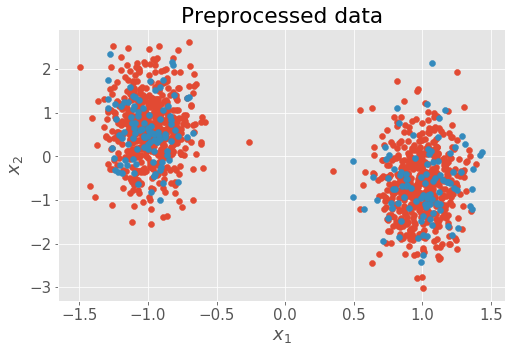

In [29]:
plt.figure()
plt.scatter(*train_data.numpy().T, label='Training')
plt.scatter(*test_data.numpy().T, label='Testing')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Preprocessed data')

### Define network and callback objects

In [30]:
# Define small network
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 1)
        
    def forward(self, x):
        x = torch.relu_(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [31]:
# model, loss function, optimizer
model = Net()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# lookback
cmatrix = CMatrix(labels=('Noise', 'Signal'))
binhist = BinHist(labels=('Noise', 'Signal'))

### Start training

In [32]:
def test():    
    model.eval()
    
    # Reset callbacks
    cmatrix.reset()
    binhist.reset()
    
    loss = 0.
    with torch.no_grad():
        for n_batch, (data, targets) in enumerate(test_loader):
            scores = model(data)
            loss += criterion(scores, targets)
            pred = scores.round()
            cmatrix.update(pred, targets)
            binhist.update(pred, targets)
        loss /= len(test_loader.dataset)
    return loss

In [33]:
num_epochs = 10
num_batches = len(train_loader)

# define logger
log = logger.ClassifierLogger(
    model_name='shallow-net', data_name='sklearn-blobs')

# start training
for epoch in range(num_epochs):
    train_loss = 0.
    n_data = 0.
    for n_batch, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Train on batch
        model.train()
        scores = model(data)
        loss = criterion(scores, targets)
        loss.backward()
        optimizer.step()
        
        # Update train loss
        train_loss += loss
        n_data += len(data)
    
        # Log error and Display progress
        if n_batch % 10 == 0:
            
            train_loss_display = train_loss/n_data
            
            # Test on test dataset
            test_loss_display = test()
            
            # log error
            log.log_metric(
                train_loss_display, test_loss_display, 'error',
                epoch, n_batch, num_batches)
            
            # log binary histogram and confusion matrices
            log.save_binhist(binhist, epoch, n_batch)
            log.save_cmatrix(cmatrix, epoch, n_batch)
            
            # display status
            log.display_status(
                epoch, num_epochs, n_batch, num_batches,
                train_loss_display, test_loss_display, 'loss'
            )
            
            # log model every epochs
            log.save_models(model, epoch, n_batch)

Epoch: [0/10], Batch Num: [0/32]
Train loss: 0.0201, Test loss: 0.0235
Epoch: [0/10], Batch Num: [10/32]
Train loss: 0.0204, Test loss: 0.0231
Epoch: [0/10], Batch Num: [20/32]
Train loss: 0.0204, Test loss: 0.0228
Epoch: [0/10], Batch Num: [30/32]
Train loss: 0.0202, Test loss: 0.0225
Epoch: [1/10], Batch Num: [0/32]
Train loss: 0.0191, Test loss: 0.0224
Epoch: [1/10], Batch Num: [10/32]
Train loss: 0.0195, Test loss: 0.0221
Epoch: [1/10], Batch Num: [20/32]
Train loss: 0.0195, Test loss: 0.0218
Epoch: [1/10], Batch Num: [30/32]
Train loss: 0.0194, Test loss: 0.0214
Epoch: [2/10], Batch Num: [0/32]
Train loss: 0.0182, Test loss: 0.0214
Epoch: [2/10], Batch Num: [10/32]
Train loss: 0.0185, Test loss: 0.0210
Epoch: [2/10], Batch Num: [20/32]
Train loss: 0.0186, Test loss: 0.0207
Epoch: [2/10], Batch Num: [30/32]
Train loss: 0.0184, Test loss: 0.0203
Epoch: [3/10], Batch Num: [0/32]
Train loss: 0.0172, Test loss: 0.0202
Epoch: [3/10], Batch Num: [10/32]
Train loss: 0.0175, Test loss: 0.0